In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

from scipy.stats import binned_statistic_2d

data=pd.read_csv('yellow_tripdata_2016-05.csv', parse_dates=[1,2],
                usecols=range(7))

mask_dist=data.trip_distance>0

mask_time=(data.tpep_dropoff_datetime>data.tpep_pickup_datetime)

mask_long=((data.pickup_longitude>=-74.25559) & (data.pickup_longitude<=-73.70001))

mask_lat=((data.pickup_latitude>=40.49612) & (data.pickup_latitude<=40.91553))

mask_pas=data.passenger_count>0

df=data.loc[mask_dist & mask_long & mask_lat & mask_time & mask_pas]

df.tpep_pickup_datetime=df.tpep_pickup_datetime.dt.floor('1h')

regions=pd.read_csv('regions.csv', sep=';')

statistic = binned_statistic_2d(df['pickup_longitude'].values, 
                                   df['pickup_latitude'].values,
                                   df.passenger_count,            #### Тут может использоваться любой столбец
                                   statistic='count', 
                                  bins=[np.union1d(regions.west, regions.east), 
                                        np.union1d(regions.south, regions.north)], 
                                  expand_binnumbers=True)
                                  
df['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

agg=pd.DataFrame(index=np.unique(df.tpep_pickup_datetime), columns=regions.region.values)

def shape0(df):
    return df.shape[0]

a=df[['tpep_pickup_datetime', 'region', 'VendorID']].groupby(['tpep_pickup_datetime', 'region']).apply(shape0)

b=a.unstack()

b.fillna(0, inplace=True)

agg.fillna(0, inplace=True)

c=agg+b

c.fillna(0, inplace=True)

c=c.astype(int)

regions.index=regions.region
regions.drop(['region'], axis=1, inplace=True)

In [3]:
c

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-31 20:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-31 21:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-31 22:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Пар час-ячейка без поездок

In [19]:
print(f'Ячеек без поездки было: {(c==0).sum().sum()}')

Ячеек без поездки было: 1718238


## Работа с геоданными

In [3]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [94]:
west=-74.25559
east=-73.70001
south=40.49612
north=40.91553

In [42]:
ESB_lat=40.7484
ESB_lon=-73.9857

### Empire state building

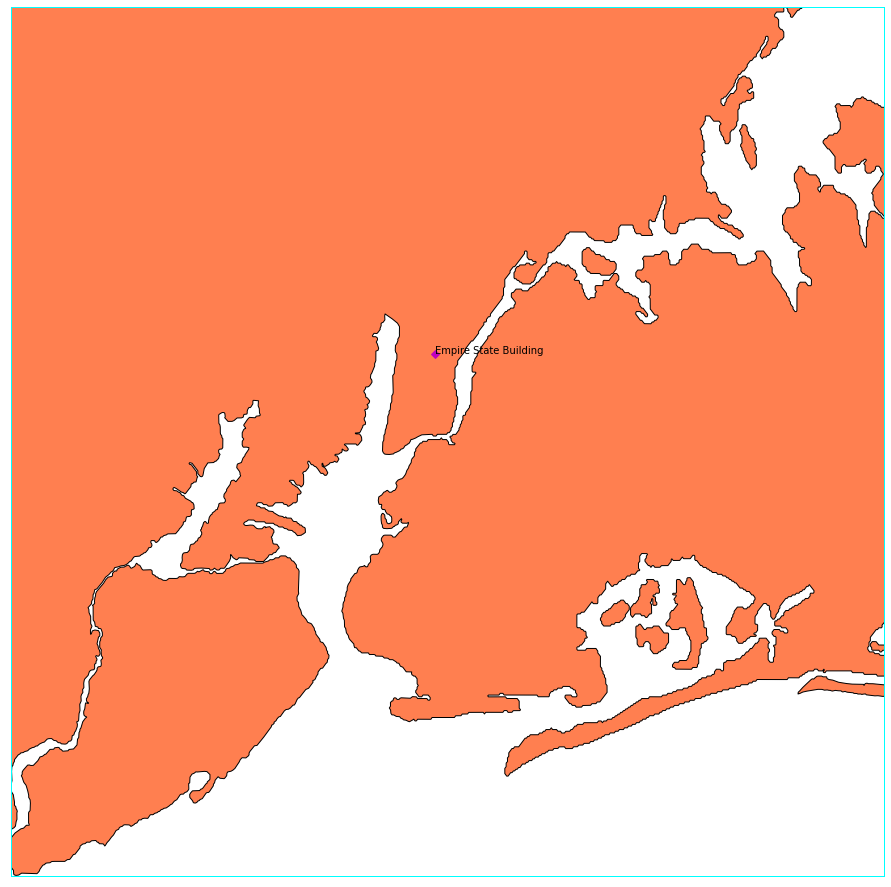

In [166]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
map = Basemap(projection='merc',
              resolution='f',
              lat_0=(north+south)/2, lon_0=(west+east)/2,
              llcrnrlon=west, llcrnrlat=south,
              urcrnrlon=east, urcrnrlat=north)


map.fillcontinents(color='coral',lake_color='aqua')
map.drawrivers()
map.drawmapboundary(color='aqua')
map.drawcoastlines()

x,y=map(ESB_lon, ESB_lat)
plt.plot(x,y, marker='D', color='m')
plt.text(x,y,'Empire State Building', fontsize=10)


plt.show()

### Добавим в таблицу regions данные о поездках из каждой ячейки за май

In [71]:
statistic[3]

array([[25, 24, 24, ..., 23, 25, 28],
       [33, 30, 30, ..., 27, 32, 11]], dtype=int64)

In [20]:
regions['v']=c.sum()

In [72]:
regions

,west,east,south,north,v
region,,,,,
1,-74.255590,-74.244478,40.496120,40.504508,0
2,-74.255590,-74.244478,40.504508,40.512896,0
3,-74.255590,-74.244478,40.512896,40.521285,0
4,-74.255590,-74.244478,40.521285,40.529673,0
5,-74.255590,-74.244478,40.529673,40.538061,0
...,...,...,...,...,...
2496,-73.711122,-73.700010,40.873589,40.881977,0
2497,-73.711122,-73.700010,40.881977,40.890365,0
2498,-73.711122,-73.700010,40.890365,40.898754,0


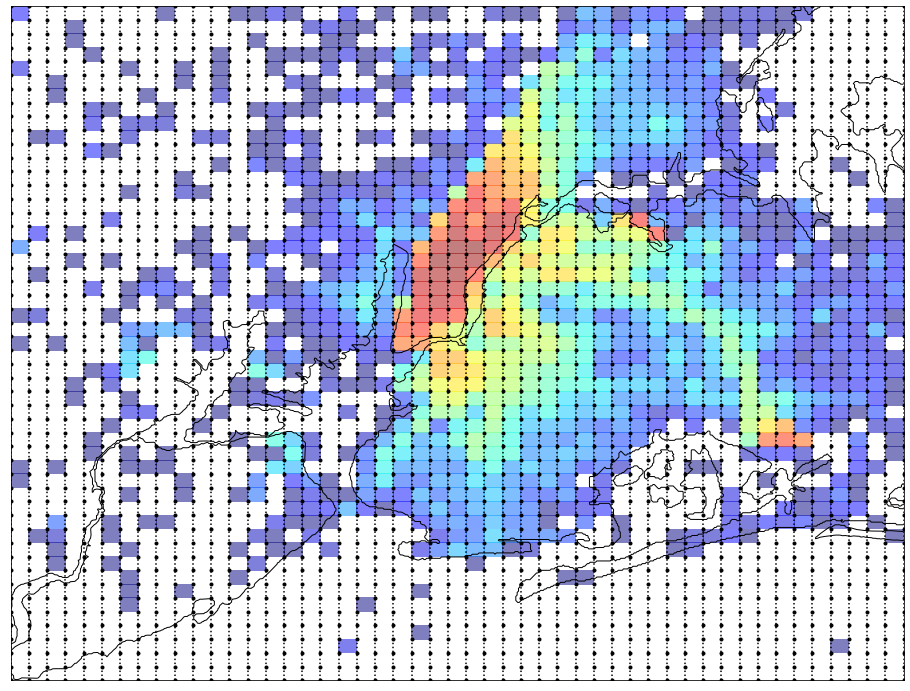

In [216]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
map = Basemap(projection='cyl',
              resolution='f',
              lat_0=(north+south)/2, lon_0=(west+east)/2,
              llcrnrlon=west, llcrnrlat=south,
              urcrnrlon=east, urcrnrlat=north)


map.drawcoastlines()

data=c.sum().values.reshape((50,50), order='F')

x = np.linspace(west, east, data.shape[1])
y = np.linspace(south, north, data.shape[0])

xx, yy = np.meshgrid(x, y)

plt.plot(xx, yy, color='black', marker='o', markersize=3, linestyle=':')

map.pcolormesh(xx, yy, np.log(data), cmap='jet', latlon=True, alpha=0.5)

plt.show()

## Интерактивные карты

In [10]:
import folium

In [97]:
m = folium.Map(location=[40.68, -74.04], zoom_start=12, tiles='stamentoner')

folium.Marker(
    location=[40.6892, -74.0445],
    popup="Statue of Liberty",
    icon=folium.Icon(icon="cloud"),
).add_to(m)
m

## Среднее количество поездок за час

In [22]:
regions['m']=c.loc['2016-05-10 4:00']

In [18]:
regions.index[regions.m>5].values

array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
       1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
       1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
       1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
       1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
       1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
       1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
       1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
       1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
       2118, 2119, 2168], dtype=int64)

In [29]:
new=pd.DataFrame(columns=['lat', 'long', 'm'], index=regions.index)

new.long=(regions.iloc[:,0]+regions.iloc[:,1])/2
new.lat=(regions.iloc[:,2]+regions.iloc[:,3])/2
new.m=np.log2(regions['m'].values)

In [25]:
import folium

from folium.plugins import HeatMap

In [30]:
m = folium.Map([40.6, -74.0], tiles="stamentoner", zoom_start=10)

HeatMap(new.values).add_to(m)

m

## Количество ячеек, из которых среднее количество поездок в час больше 5

In [87]:
print(f'Ячеек, из которых среднее количество поездок в час больше 5 : {np.where(new.m<5, 0, 1).sum()}')

Ячеек, из которых среднее количество поездок в час больше 5 : 102


## Проверим на карте

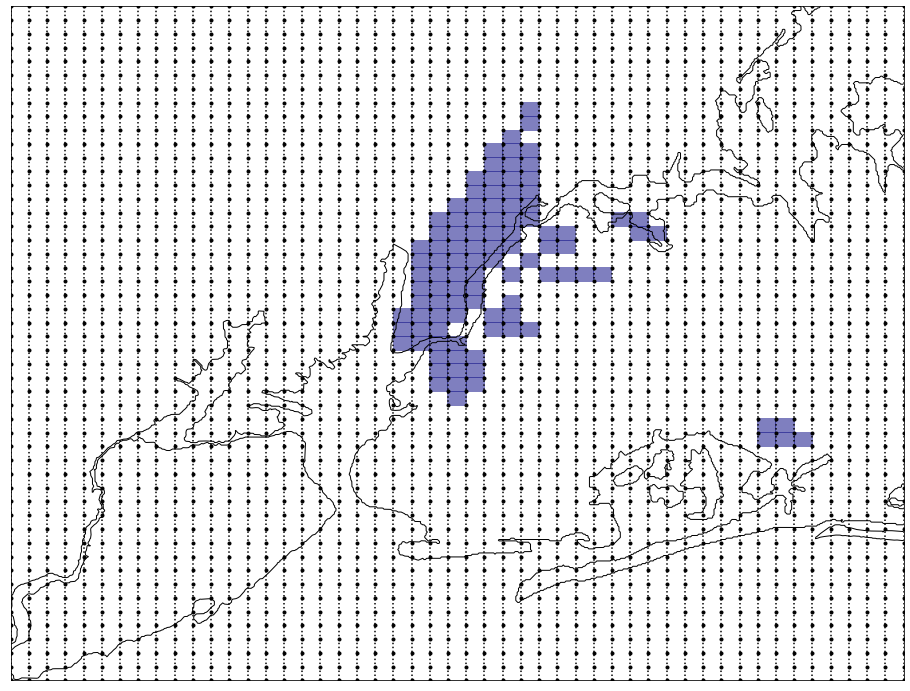

In [96]:
plt.figure(figsize=(16,16))
map = Basemap(projection='cyl',
              resolution='f',
              lat_0=(north+south)/2, lon_0=(west+east)/2,
              llcrnrlon=west, llcrnrlat=south,
              urcrnrlon=east, urcrnrlat=north)


map.drawcoastlines()

data=np.where(c.mean().values.reshape((50,50), order='F')<5, 0, 1)

x = np.linspace(west, east, data.shape[1])
y = np.linspace(south, north, data.shape[0])

xx, yy = np.meshgrid(x, y)

plt.plot(xx, yy, color='black', marker='o', markersize=3, linestyle=':')

map.pcolormesh(xx, yy, np.log(data), cmap='jet', latlon=True, alpha=0.5)

plt.show()

### Возможно есть 1-2 квдрата, из которых заказ невозможен, потому что они находятся на воде, однако все же небольшой участок суши захватывается, поэтому сказать трудно.

In [32]:
regions

,west,east,south,north,m
region,,,,,
1,-74.255590,-74.244478,40.496120,40.504508,0
2,-74.255590,-74.244478,40.504508,40.512896,0
3,-74.255590,-74.244478,40.512896,40.521285,0
4,-74.255590,-74.244478,40.521285,40.529673,0
5,-74.255590,-74.244478,40.529673,40.538061,0
...,...,...,...,...,...
2496,-73.711122,-73.700010,40.873589,40.881977,0
2497,-73.711122,-73.700010,40.881977,40.890365,0
2498,-73.711122,-73.700010,40.890365,40.898754,0


In [34]:
regions.index=regions.index.astype('str')

In [38]:
regions.index.values

array(['1', '2', '3', ..., '2498', '2499', '2500'], dtype=object)

In [50]:
regions.m=regions.m.astype('int')

In [52]:
regions.m

region
1       0
2       0
3       0
4       0
5       0
       ..
2496    0
2497    0
2498    0
2499    0
2500    0
Name: m, Length: 2500, dtype: int32

In [72]:
l=[]
for i, S in regions.iterrows():
    if S.m!=0:
        l.extend([i]*int(S.m))

In [1]:
import streamlit as st

In [2]:
st.__version__

'0.80.0'

In [3]:
import plotly

In [4]:
plotly.__version__

'4.14.3'

In [1]:
import pandas as pd

In [2]:
r=pd.read_csv('regions.csv', ';', index_col=0)

In [3]:
r

,west,east,south,north
region,,,,
1,-74.255590,-74.244478,40.496120,40.504508
2,-74.255590,-74.244478,40.504508,40.512896
3,-74.255590,-74.244478,40.512896,40.521285
4,-74.255590,-74.244478,40.521285,40.529673
5,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...
2496,-73.711122,-73.700010,40.873589,40.881977
2497,-73.711122,-73.700010,40.881977,40.890365
2498,-73.711122,-73.700010,40.890365,40.898754


In [4]:
reg=r[r.index==1075]

reg['avg_trips']=10

<ipython-input-4-3d0f8432dfd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['avg_trips']=10


In [5]:
reg['lon']=(reg.iloc[:,0]+reg.iloc[:,1])/2
reg['lat']=(reg.iloc[:,2]+reg.iloc[:,3])/2

k=[]
for i, S in reg.iterrows():
    if S.avg_trips!=0:
        k.extend([i]*int(S.avg_trips))

reg.loc[k][['lon', 'lat']]

<ipython-input-5-ec8669c0d721>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['lon']=(reg.iloc[:,0]+reg.iloc[:,1])/2
<ipython-input-5-ec8669c0d721>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['lat']=(reg.iloc[:,2]+reg.iloc[:,3])/2


,lon,lat
region,,
1075,-74.016691,40.701631
1075,-74.016691,40.701631
1075,-74.016691,40.701631
1075,-74.016691,40.701631
1075,-74.016691,40.701631
1075,-74.016691,40.701631
1075,-74.016691,40.701631
1075,-74.016691,40.701631
1075,-74.016691,40.701631


In [6]:
int(5.295)

5

In [14]:
import numpy as np

In [16]:
np.round(reg.lon.values[0],3)

-74.017